# Requesting Argo data from Ifremer erddap, expert mode

Using the expert mode, you can have access to all fields retrieved from the erddap, including all QC variables and without any data mode filtering.

***
Script prepared by [Guillaume Maze](http://github.com/gmaze)
<div>
<img src="http://www.argo-france.fr/wp-content/uploads/2019/10/Argo-logo_banner-color.png" width="200"/>
<img src="https://www.umr-lops.fr/var/storage/images/_aliases/logo_main/medias-ifremer/medias-lops/logos/logo-lops-2/1459683-4-fre-FR/Logo-LOPS-2.png" width="70"/>
</div>

In [1]:
import sys, os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import cmocean
%matplotlib inline

sys.path.insert(0, os.path.abspath('..'))
from fetchers import ArgoDataFetcher

# Usefull colormaps and colorbar makers:
qcmap = mpl.colors.ListedColormap(['#000000', 
                                   '#31FC03', 
                                   '#ADFC03', 
                                   '#FCBA03', 
                                   '#FC1C03',
                                   '#324CA8', 
                                   '#000000', 
                                   '#000000', 
                                   '#B22CC9', 
                                   '#000000'])
def colorbar_qc(cmap, **kwargs):
    """Adjust colorbar ticks with discrete colors for QC flags"""
    ncolors = 10
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    return colorbar

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['A','D','R'])

dmode_map = mpl.colors.ListedColormap(['#FCBA03','#31FC03','#FF0000'])
def colorbar_dmode(cmap=dmode_map, **kwargs):
    """Adjust colorbar ticks with discrete colors for DATA MODE"""
    ncolors = 3
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(le.classes_)
    return colorbar


In [2]:
argo_loader = ArgoDataFetcher(mode='expert')
argo_loader

<datafetcher 'Not initialised'>
User mode: expert

# Example of data fetching for a specific region

In [3]:
box = [-80., 0., 26-0.5, 26+.5, 0, 1000, '2018-01-01','2018-12-31']
argo = argo_loader.region(box).to_xarray()
argo

<xarray.Dataset>
Dimensions:              (index: 84912)
Coordinates:
    time                 (index) datetime64[ns] 2018-01-01T20:16:00 ... 2018-12-30T15:47:00
    longitude            (index) float64 -15.47 -15.47 -15.47 ... -63.1 -63.1
  * index                (index) int64 0 1 2 3 4 ... 84908 84909 84910 84911
    latitude             (index) float64 26.08 26.08 26.08 ... 25.72 25.72 25.72
Data variables:
    CYCLE_NUMBER         (index) int64 97 97 97 97 97 97 ... 236 236 236 236 236
    DATA_MODE            (index) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D' 'D'
    DIRECTION            (index) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER      (index) int64 6901620 6901620 ... 6901183 6901183
    POSITION_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PRES                 (index) float64 6.0 7.0 8.0 9.0 ... 975.2 985.1 993.2
    PRES_ADJUSTED        (index) float64 6.0 7.0 8.0 9.0 ... 975.2 985.1 993.2
    PRES_ADJUSTED_ERROR  (index) float64 2.4 2.4 2.4 2.4 2.4 ... 5.0 5.0 5.0 5.0
    PRES_ADJUSTED_QC     (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PRES_QC              (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PSAL                 (index) float64 36.81 36.81 36.81 ... 35.08 35.08 35.08
    PSAL_ADJUSTED        (index) float64 36.81 36.81 36.81 ... 35.08 35.08 35.08
    PSAL_ADJUSTED_ERROR  (index) float64 0.01 0.01 0.01 0.01 ... 0.01 0.01 0.01
    PSAL_ADJUSTED_QC     (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PSAL_QC              (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TEMP                 (index) float64 19.76 19.76 19.76 ... 6.986 6.888 6.792
    TEMP_ADJUSTED        (index) float64 19.76 19.76 19.76 ... 6.986 6.888 6.792
    TEMP_ADJUSTED_ERROR  (index) float64 0.002 0.002 0.002 ... 0.01 0.01 0.01
    TEMP_ADJUSTED_QC     (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TEMP_QC              (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TIME_QC              (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:               ARGO
    DOI:                   http://doi.org/10.17882/42182
    Downloaded_from:       http://www.ifremer.fr/erddap
    Downloaded_by:         gmaze
    Download_date:         2020/02/26
    Download_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats.c...
    Download_constraints:  [x=-80.00/0.00; y=25.50/26.50; z=0.0/1000.0; t=201...
    cache:                 cache/TSargo_28000_00000_02550_02650_00000_10000_2...

## QC figure with unfiltered data

/Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


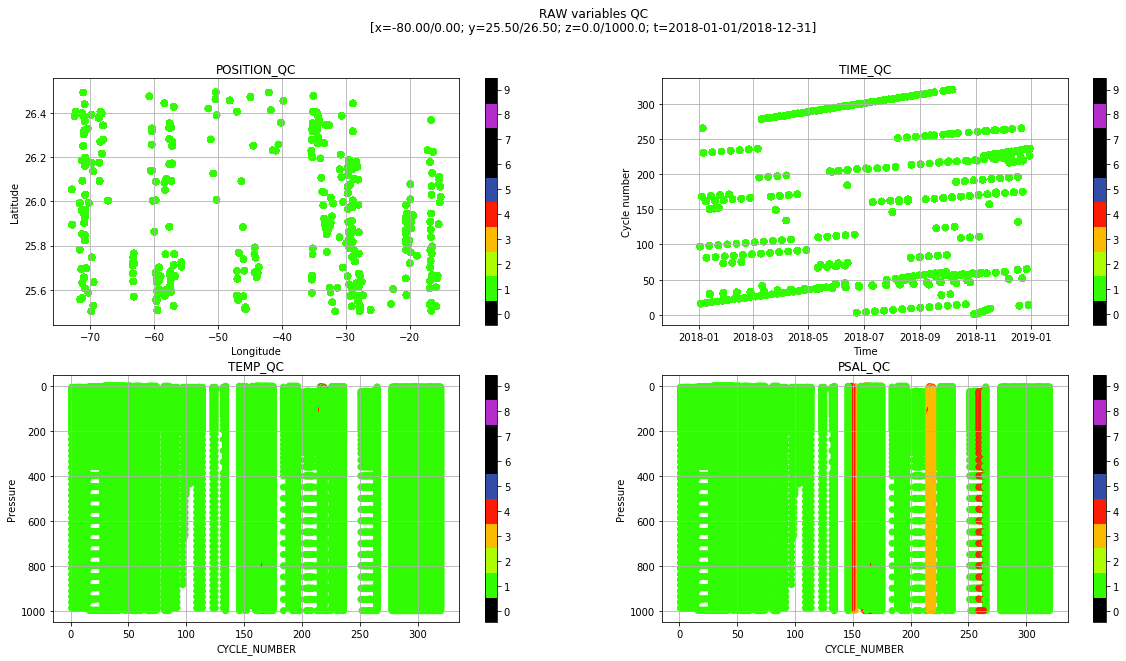

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo['longitude'], argo['latitude'], c=argo['POSITION_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Latitude')
ax[ix].set_title('POSITION_QC')

ix += 1
sc = ax[ix].scatter(argo['time'].values, argo['CYCLE_NUMBER'], c=argo['TIME_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Time')
ax[ix].set_ylabel('Cycle number')
ax[ix].set_title('TIME_QC')

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['TEMP_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('TEMP_QC')

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['PSAL_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('PSAL_QC')

fig.suptitle("RAW variables QC\n%s" % argo.attrs['Download_constraints']);

## Data mode

But this is (nearly) the raw output of the request. It could be useful to simply select the most appropriate variables according to the data mode (Real time, adjusted and delayed mode). 

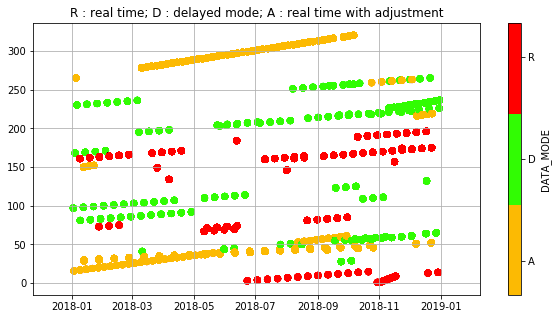

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax = np.array(ax).flatten()
sc = ax[0].scatter(argo['time'].values, argo['CYCLE_NUMBER'], c=le.transform(argo['DATA_MODE']), 
            vmin=0, vmax=2, cmap=dmode_map)
colorbar_dmode(label='DATA_MODE', ax=ax[0])
ax[0].grid()
ax[0].set_title(argo['DATA_MODE'].attrs['convention']);

## Filter data according to data mode

In [6]:
argo_filtered = argo_loader.region(box).fetcher.filter_data_mode(argo)

## QC figure with appropriate variables

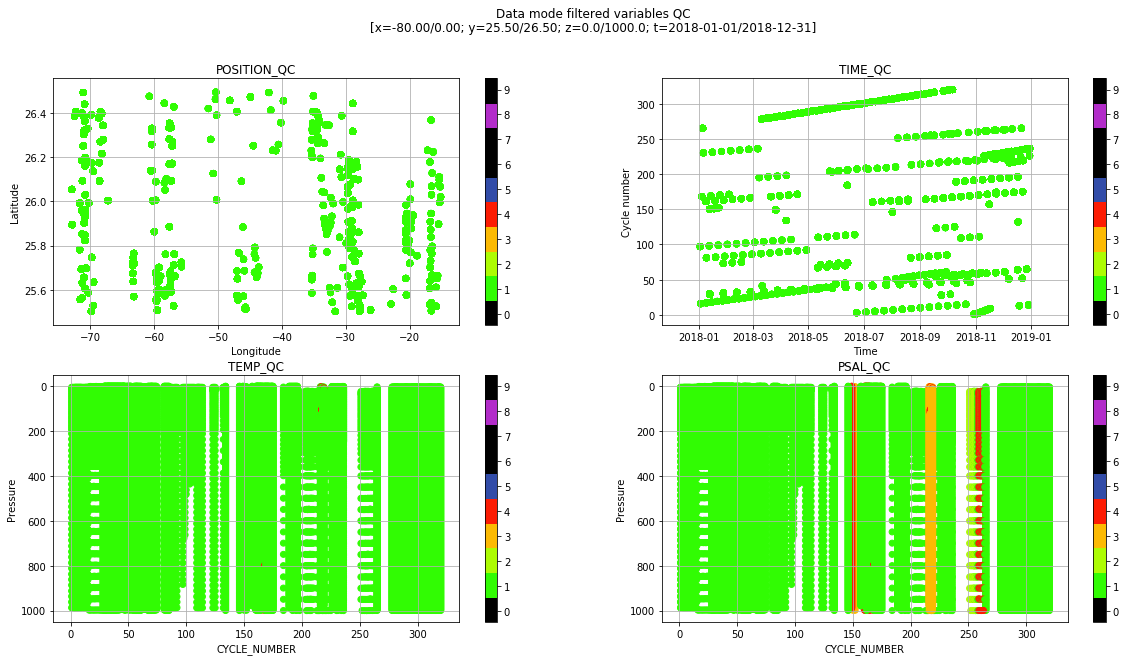

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo_filtered['longitude'], argo_filtered['latitude'], c=argo_filtered['POSITION_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Latitude')
ax[ix].set_title('POSITION_QC')

ix += 1
sc = ax[ix].scatter(argo_filtered['time'].values, argo_filtered['CYCLE_NUMBER'], c=argo_filtered['TIME_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Time')
ax[ix].set_ylabel('Cycle number')
ax[ix].set_title('TIME_QC')

ix += 1
sc = ax[ix].scatter(argo_filtered['CYCLE_NUMBER'], argo_filtered['PRES'], c=argo_filtered['TEMP_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('TEMP_QC')

ix += 1
sc = ax[ix].scatter(argo_filtered['CYCLE_NUMBER'], argo_filtered['PRES'], c=argo_filtered['PSAL_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('PSAL_QC')

fig.suptitle("Data mode filtered variables QC\n%s" % argo.attrs['Download_constraints']);

# Example of data fetching for a specific float

In [8]:
float_fetcher = argo_loader.float(6902746)
argo_unfiltered = float_fetcher.to_xarray()
argo = float_fetcher.fetcher.filter_data_mode(argo_unfiltered)

In [9]:
argo_unfiltered.where(argo_unfiltered['CYCLE_NUMBER']==90,drop=1)

<xarray.Dataset>
Dimensions:              (index: 109)
Coordinates:
  * index                (index) int64 9480 9481 9482 9483 ... 9586 9587 9588
    latitude             (index) float64 16.36 16.36 16.36 ... 16.36 16.36 16.36
    longitude            (index) float64 -64.0 -64.0 -64.0 ... -64.0 -64.0 -64.0
    time                 (index) datetime64[ns] 2019-04-14T07:01:00 ... 2019-04-14T07:01:00
Data variables:
    CYCLE_NUMBER         (index) float64 90.0 90.0 90.0 90.0 ... 90.0 90.0 90.0
    DATA_MODE            (index) object 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    DIRECTION            (index) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER      (index) float64 6.903e+06 6.903e+06 ... 6.903e+06
    POSITION_QC          (index) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    PRES                 (index) float64 3.0 4.0 5.0 ... 1.988e+03 2.007e+03
    PRES_ADJUSTED        (index) float64 3.0 4.0 5.0 ... 1.988e+03 2.007e+03
    PRES_ADJUSTED_ERROR  (index) float64 2.4 2.4 2.4 2.4 2.4 ... 2.4 2.4 2.4 2.4
    PRES_ADJUSTED_QC     (index) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    PRES_QC              (index) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    PSAL                 (index) float64 36.05 36.05 36.05 ... 34.99 34.99 34.99
    PSAL_ADJUSTED        (index) float64 nan nan nan nan nan ... nan nan nan nan
    PSAL_ADJUSTED_ERROR  (index) float64 nan nan nan nan nan ... nan nan nan nan
    PSAL_ADJUSTED_QC     (index) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
    PSAL_QC              (index) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    TEMP                 (index) float64 26.72 26.72 26.72 ... 4.133 4.135 4.137
    TEMP_ADJUSTED        (index) float64 26.72 26.72 26.72 ... 4.133 4.135 4.137
    TEMP_ADJUSTED_ERROR  (index) float64 0.002 0.002 0.002 ... 0.002 0.002 0.002
    TEMP_ADJUSTED_QC     (index) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    TEMP_QC              (index) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    TIME_QC              (index) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    DATA_ID:               ARGO
    DOI:                   http://doi.org/10.17882/42182
    Downloaded_from:       http://www.ifremer.fr/erddap
    Downloaded_by:         gmaze
    Download_date:         2020/02/26
    Download_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats.c...
    Download_constraints:  WMO6902746
    cache:                 cache/TSargo_WMO6902746.nc

In [10]:
# Get basic information about the float:
print('This float has performed: %i profiles' % len(np.unique(argo['CYCLE_NUMBER'])))
print('This float operated between %s and %s' % (argo['time'].min().values, argo['time'].max().values))
print('This float profiles range from %0.1fdb to %0.1fdb' % (argo['PRES'].min(), argo['PRES'].max() ))

This float has performed: 121 profiles
This float operated between 2017-07-06T14:49:00.000000000 and 2020-02-18T07:19:00.000000000
This float profiles range from 3.0db to 2037.0db


## Plot trajectory

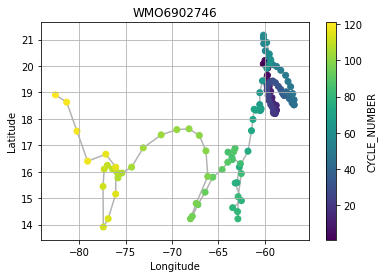

In [11]:
this = argo.reset_coords().groupby('CYCLE_NUMBER').min()
plt.plot(this['longitude'], this['latitude'], '-', color=[0.7]*3, zorder=0)
plt.scatter(this['longitude'], this['latitude'], c=this['CYCLE_NUMBER'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().grid()
plt.colorbar(label='CYCLE_NUMBER')
plt.title(argo.attrs['Download_constraints'])
plt.show()

## QC flags for appropriate variables

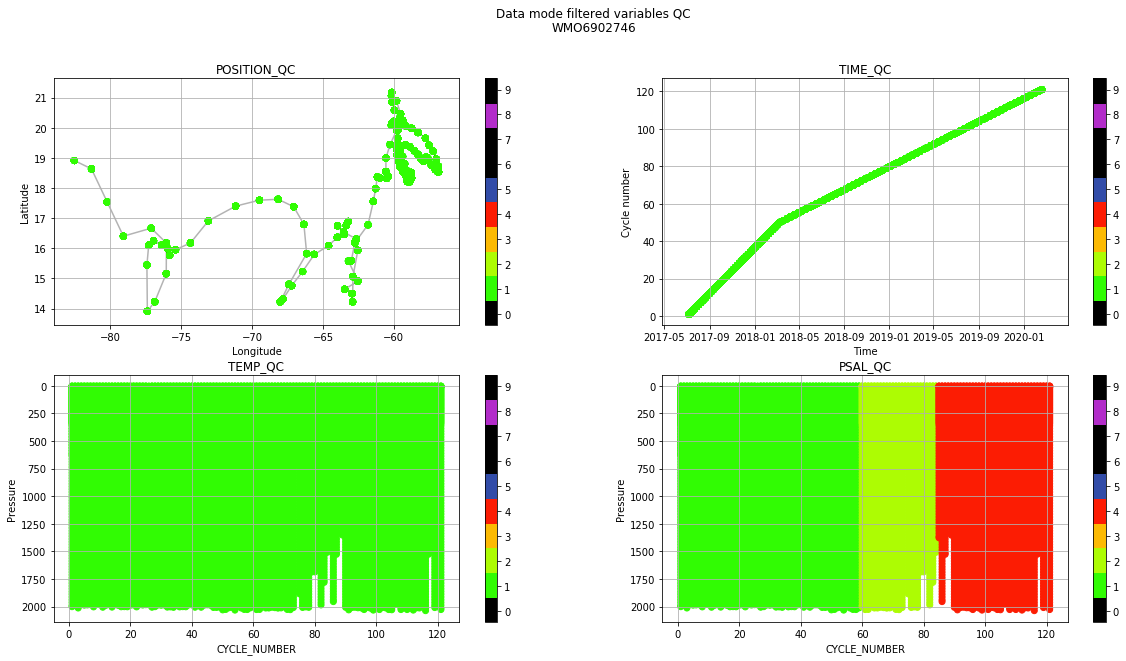

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = np.array(ax).flatten()

ix = 0
ax[ix].plot(argo['longitude'], argo['latitude'], '-', color=[0.7]*3, zorder=0)
sc = ax[ix].scatter(argo['longitude'], argo['latitude'], c=argo['POSITION_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Latitude')
ax[ix].set_title('POSITION_QC')

ix += 1
sc = ax[ix].scatter(argo['time'].values, argo['CYCLE_NUMBER'], c=argo['TIME_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Time')
ax[ix].set_ylabel('Cycle number')
ax[ix].set_title('TIME_QC')

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['TEMP_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('TEMP_QC')

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['PSAL_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('PSAL_QC')

fig.suptitle("Data mode filtered variables QC\n%s" % argo.attrs['Download_constraints']);

## DATA MODE

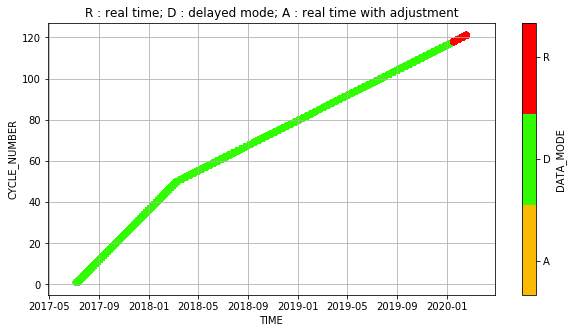

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax = np.array(ax).flatten()
sc = ax[0].scatter(argo['time'].values, argo['CYCLE_NUMBER'], c=le.transform(argo['DATA_MODE']), 
            vmin=0, vmax=2, cmap=dmode_map)
colorbar_dmode(label='DATA_MODE', ax=ax[0])
ax[0].set_ylabel('CYCLE_NUMBER')
ax[0].set_xlabel('TIME')
ax[0].grid()
ax[0].set_title(argo['DATA_MODE'].attrs['convention']);

## Hovmoller

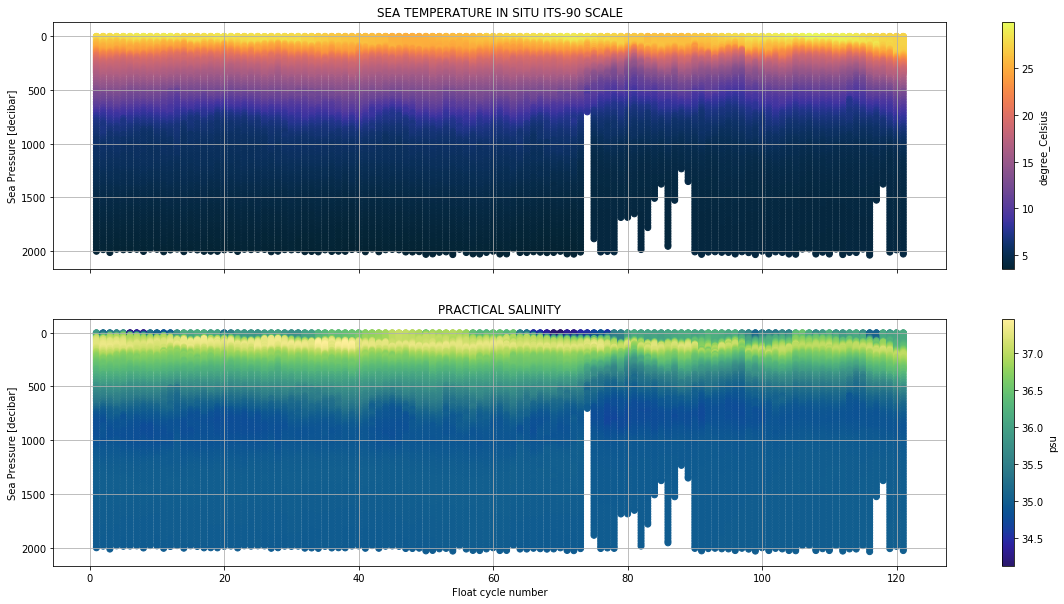

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True, sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['TEMP'], cmap=cmocean.cm.thermal)
plt.colorbar(sc, ax=ax[ix], label=argo['TEMP'].attrs['units'])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['PSAL'], cmap=cmocean.cm.haline)
plt.colorbar(sc, ax=ax[ix], label=argo['PSAL'].attrs['units'])
ax[ix].grid()
# ax[ix].invert_yaxis()
ax[ix].set_xlabel(argo['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['PSAL'].attrs['long_name']);

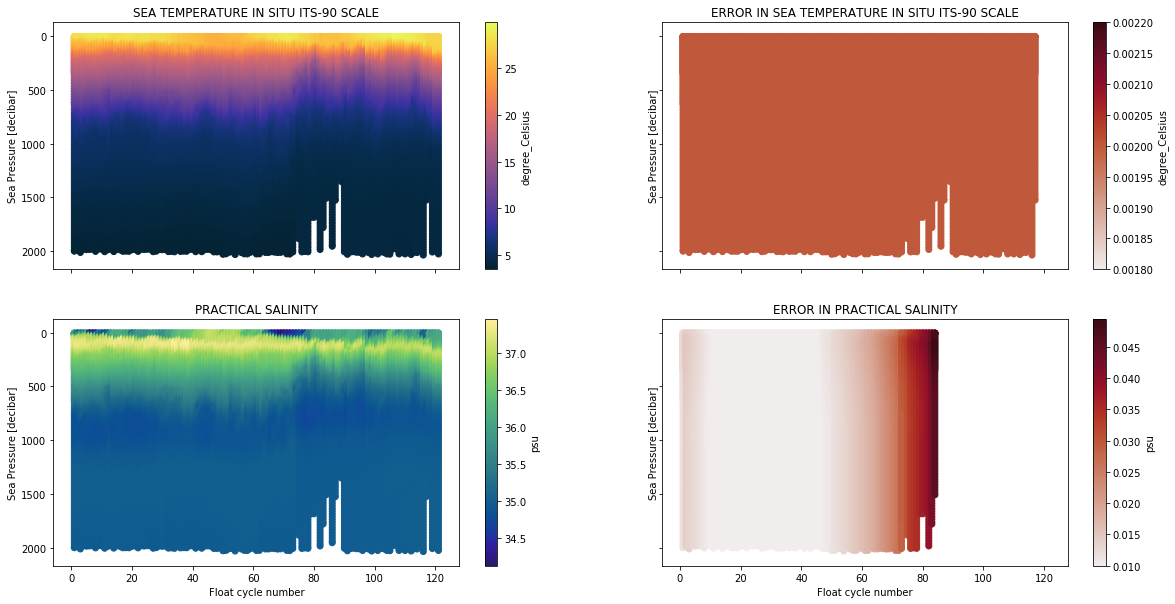

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10), sharex=True, sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['TEMP'], cmap=cmocean.cm.thermal)
plt.colorbar(sc, ax=ax[ix], label=argo['TEMP'].attrs['units'])
ax[ix].invert_yaxis()
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['TEMP_ERROR'], cmap=cmocean.cm.amp)
plt.colorbar(sc, ax=ax[ix], label=argo['TEMP_ERROR'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['TEMP_ERROR'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['PSAL'], cmap=cmocean.cm.haline)
plt.colorbar(sc, ax=ax[ix], label=argo['PSAL'].attrs['units'])
ax[ix].set_xlabel(argo['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['PSAL'].attrs['long_name']);

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['PSAL_ERROR'], cmap=cmocean.cm.amp)
plt.colorbar(sc, ax=ax[ix], label=argo['PSAL_ERROR'].attrs['units'])
ax[ix].set_xlabel(argo['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['PSAL_ERROR'].attrs['long_name']);

## Super-imposed profiles

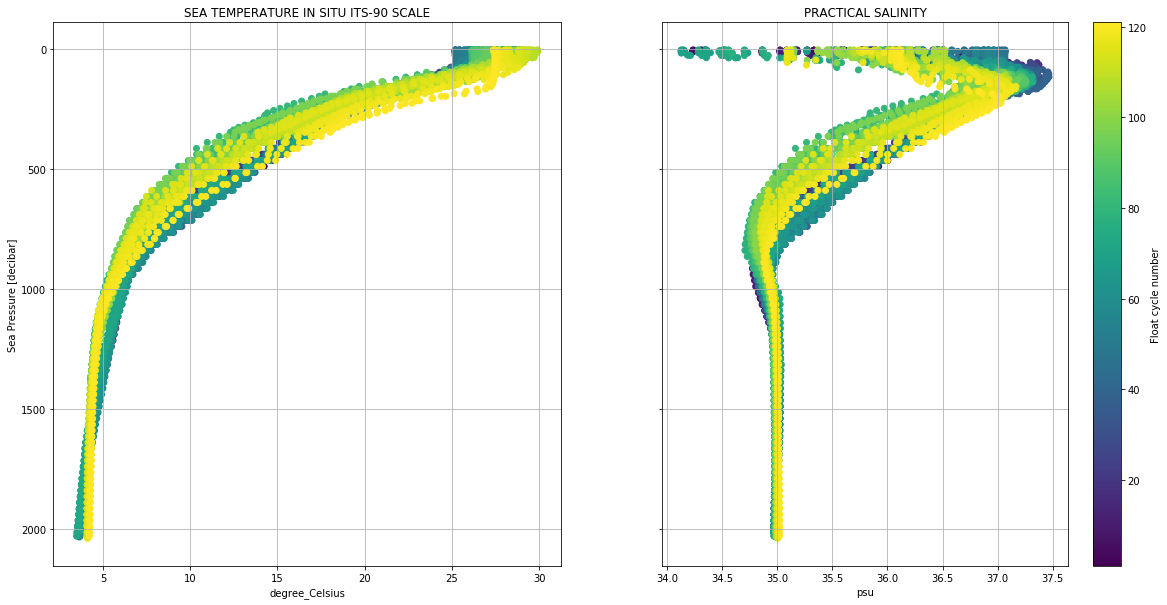

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo['TEMP'], argo['PRES'], c=argo['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel(argo['TEMP'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo['PSAL'], argo['PRES'], c=argo['CYCLE_NUMBER'])
plt.colorbar(sc, ax=ax[ix], label=argo['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].grid()
ax[ix].set_xlabel(argo['PSAL'].attrs['units'])
ax[ix].set_title(argo['PSAL'].attrs['long_name']);


## T/S diagram

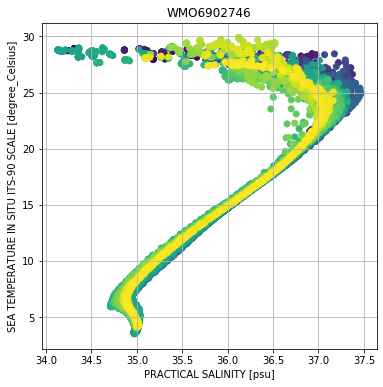

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
ax = np.array(ax).flatten()
ix = 0
sc = ax[ix].scatter(argo['PSAL'], argo['TEMP'], c=argo['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].set_xlabel("%s [%s]" % (argo['PSAL'].attrs['long_name'], argo['PSAL'].attrs['units']))
ax[ix].set_ylabel("%s [%s]" % (argo['TEMP'].attrs['long_name'], argo['TEMP'].attrs['units']))
plt.title(argo.attrs['Download_constraints']);

## Filter data according to QC flags

In [18]:
argo_ok = float_fetcher.fetcher.filter_qc(argo)

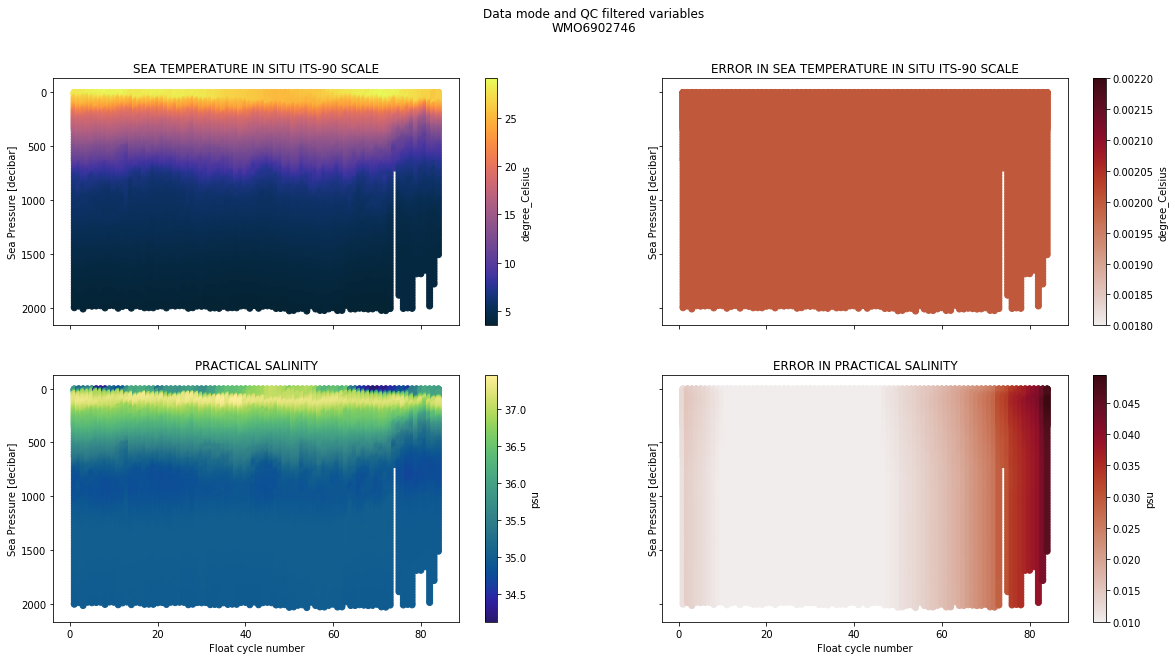

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10), sharex=True, sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo_ok['CYCLE_NUMBER'], argo_ok['PRES'], c=argo_ok['TEMP'], cmap=cmocean.cm.thermal)
plt.colorbar(sc, ax=ax[ix], label=argo_ok['TEMP'].attrs['units'])
ax[ix].invert_yaxis()
ax[ix].set_ylabel("%s [%s]" % (argo_ok['PRES'].attrs['long_name'], argo_ok['PRES'].attrs['units']))
ax[ix].set_title(argo_ok['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo_ok['CYCLE_NUMBER'], argo_ok['PRES'], c=argo_ok['TEMP_ERROR'], cmap=cmocean.cm.amp)
plt.colorbar(sc, ax=ax[ix], label=argo_ok['TEMP_ERROR'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (argo_ok['PRES'].attrs['long_name'], argo_ok['PRES'].attrs['units']))
ax[ix].set_title(argo_ok['TEMP_ERROR'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo_ok['CYCLE_NUMBER'], argo_ok['PRES'], c=argo_ok['PSAL'], cmap=cmocean.cm.haline)
plt.colorbar(sc, ax=ax[ix], label=argo_ok['PSAL'].attrs['units'])
ax[ix].set_xlabel(argo_ok['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (argo_ok['PRES'].attrs['long_name'], argo_ok['PRES'].attrs['units']))
ax[ix].set_title(argo_ok['PSAL'].attrs['long_name']);

ix += 1
sc = ax[ix].scatter(argo_ok['CYCLE_NUMBER'], argo_ok['PRES'], c=argo_ok['PSAL_ERROR'], cmap=cmocean.cm.amp)
plt.colorbar(sc, ax=ax[ix], label=argo_ok['PSAL_ERROR'].attrs['units'])
ax[ix].set_xlabel(argo_ok['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (argo_ok['PRES'].attrs['long_name'], argo_ok['PRES'].attrs['units']))
ax[ix].set_title(argo_ok['PSAL_ERROR'].attrs['long_name']);

fig.suptitle("Data mode and QC filtered variables\n%s" % argo.attrs['Download_constraints']);

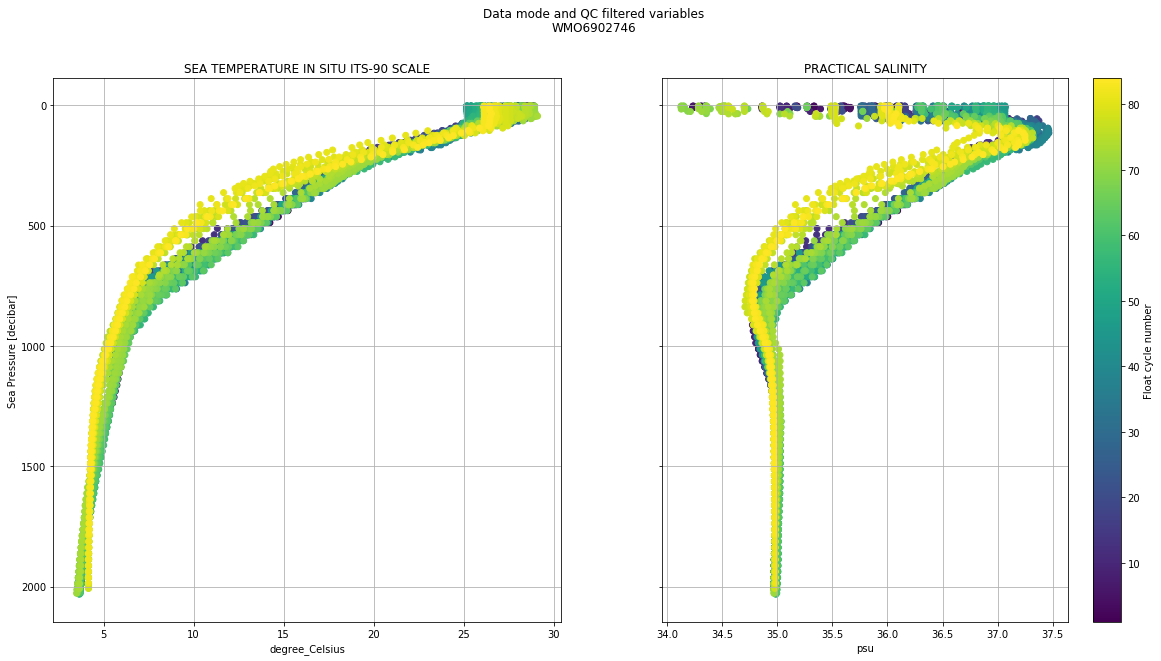

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo_ok['TEMP'], argo_ok['PRES'], c=argo_ok['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel(argo_ok['TEMP'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (argo_ok['PRES'].attrs['long_name'], argo_ok['PRES'].attrs['units']))
ax[ix].set_title(argo_ok['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo_ok['PSAL'], argo_ok['PRES'], c=argo_ok['CYCLE_NUMBER'])
plt.colorbar(sc, ax=ax[ix], label=argo_ok['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].grid()
ax[ix].set_xlabel(argo_ok['PSAL'].attrs['units'])
ax[ix].set_title(argo_ok['PSAL'].attrs['long_name']);

fig.suptitle("Data mode and QC filtered variables\n%s" % argo.attrs['Download_constraints']);